In [ ]:
# First, install the necessary libraries
!pip install transformers nltk

import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.stem import WordNetLemmatizer

# Initialization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Load data (assuming df is already loaded)
df = pd.read_csv("/testdata.csv")

# Preprocessing: Clean and Lemmatize text
def clean_and_lemmatize(text):
    # Clean text
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()

    # Lemmatize
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

df['lemmatized_text'] = df['full_text'].apply(clean_and_lemmatize)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the texts
def encode_texts(texts):
    encoded = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='tf')
    return encoded['input_ids'], encoded['attention_mask']

input_ids, attention_masks = encode_texts(df['lemmatized_text'].tolist())

# Convert TensorFlow tensors to numpy arrays for sklearn functions
input_ids_np = input_ids.numpy()
attention_masks_np = attention_masks.numpy()

# Convert categorical labels to integers
encoder = LabelEncoder()
df['encoded_label'] = encoder.fit_transform(df['sentiment_type'])
labels = df['encoded_label'].values
num_labels = len(df['encoded_label'].unique())

# Split data
train_ids_np, test_ids_np, train_masks_np, test_masks_np, train_labels, test_labels = train_test_split(
    input_ids_np, attention_masks_np, labels, test_size=0.2, random_state=42
)

# Convert numpy arrays back to tensors for training in TensorFlow
train_ids = tf.convert_to_tensor(train_ids_np)
test_ids = tf.convert_to_tensor(test_ids_np)
train_masks = tf.convert_to_tensor(train_masks_np)
test_masks = tf.convert_to_tensor(test_masks_np)

# Define BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train model
train_data = {'input_ids': train_ids, 'attention_mask': train_masks}
model.fit(train_data, train_labels, validation_split=0.1, epochs=3, batch_size=8)

# Evaluate model
test_data = {'input_ids': test_ids, 'attention_mask': test_masks}
results = model.evaluate(test_data, test_labels)
print("test loss, test acc:", results)

# Example prediction
text = ["This is an example review"]
input_id, attention_mask = encode_texts(text)
logits = model.predict({'input_ids': input_id, 'attention_mask': attention_mask})
predictions = tf.argmax(logits.logits, axis=-1).numpy()
print("Predicted label:", encoder.inverse_transform(predictions)[0])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.0 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
1486/1486 [==============================] - 128s 59ms/step - loss: 0.5328 - accuracy: 0.7942 - val_loss: 0.3949 - val_accuracy: 0.8637
Epoch 2/3
1486/1486 [==============================] - 58s 39ms/step - loss: 0.2889 - accuracy: 0.9013 - val_loss: 0.2868 - val_accuracy: 0.9061
Epoch 3/3
104/104 [==============================] - 3s 33ms/step - loss: 0.3147 - accuracy: 0.9007
test loss, test acc: [0.31467920541763306, 0.900696337223053]
1/1 [==============================] - 3s 3s/step
Predicted label: NEUTRAL


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Predict labels for test dataset
y_pred = model.predict(test_data)
y_pred_classes = tf.argmax(y_pred.logits, axis=-1).numpy()

# Calculate metrics
accuracy = accuracy_score(test_labels, y_pred_classes)
precision = precision_score(test_labels, y_pred_classes, average='weighted')
recall = recall_score(test_labels, y_pred_classes, average='weighted')
f1 = f1_score(test_labels, y_pred_classes, average='weighted')
confusion = confusion_matrix(test_labels, y_pred_classes)

# For ROC AUC Score, one-vs-all method is applied for multiclass classification
# Assuming you have 3 classes, you need to one-hot encode the true labels and predicted labels
y_true_one_hot = tf.keras.utils.to_categorical(test_labels, num_labels)
y_pred_softmax = tf.nn.softmax(y_pred.logits, axis=-1)
roc_auc = roc_auc_score(y_true_one_hot, y_pred_softmax, multi_class='ovr')

# Display results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_report(test_labels, y_pred_classes))


104/104 [==============================] - 3s 32ms/step
Accuracy: 0.9006963366636391
Precision: 0.9036842119957978
Recall: 0.9006963366636391
F1 Score: 0.9016927418810899
ROC AUC Score: 0.9691338681864474
Confusion Matrix:
 [[ 493   23   57]
 [  30  891   56]
 [ 113   49 1591]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82       573
           1       0.93      0.91      0.92       977
           2       0.93      0.91      0.92      1753

    accuracy                           0.90      3303
   macro avg       0.88      0.89      0.88      3303
weighted avg       0.90      0.90      0.90      3303



In [ ]:
!pip install seaborn
# Generate Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted labels for test data
predictions = model.predict(test_data)
logits = predictions.logits
predicted_labels = tf.argmax(logits, axis=-1).numpy()

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report for Precision, Recall, F1-Score
print(classification_report(test_labels, predicted_labels, target_names=encoder.classes_))


NameError: ignored

104/104 [==============================] - 28s 201ms/step


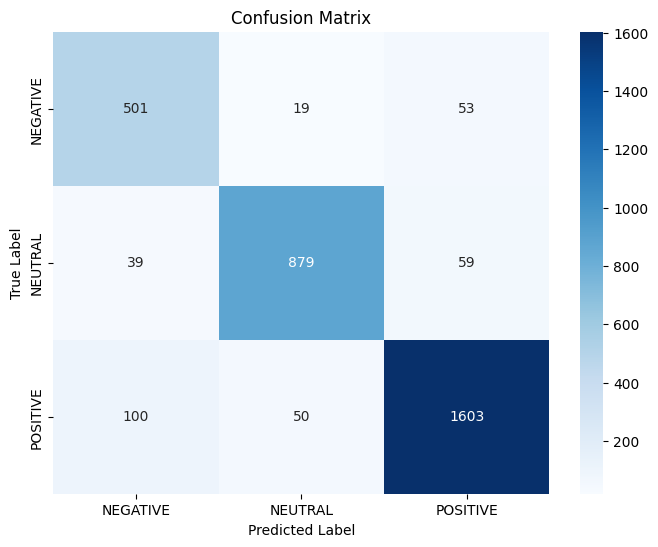

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.87      0.83       573
     NEUTRAL       0.93      0.90      0.91       977
    POSITIVE       0.93      0.91      0.92      1753

    accuracy                           0.90      3303
   macro avg       0.88      0.90      0.89      3303
weighted avg       0.91      0.90      0.90      3303



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

# Assuming the previous code is loaded...

# Get the model's predictions on the test set
y_pred = np.argmax(model.predict(test_data).logits, axis=1)

# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
conf_mat = confusion_matrix(test_labels, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 2. Precision, Recall, and F1-score
print(classification_report(test_labels, y_pred, target_names=encoder.classes_))

# 3. ROC Curve and AUC (for binary classification or for one-vs-rest)
# Note: This assumes three classes. If you have a different number, adjust accordingly.
if num_labels == 2:
    fpr, tpr, _ = roc_curve(test_labels, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
# Set the embeddings layer to trainable
model.bert.embeddings.trainable = True

# 2. Tokenize the sample text and get its embeddings
input_id, attention_mask = encode_texts([sample_text])
input_id_tensor = tf.convert_to_tensor(input_id)
attention_mask_tensor = tf.convert_to_tensor(attention_mask)

# Fetch the model's embeddings
embedding_matrix = model.bert.embeddings(input_id_tensor)

# 3. Compute the gradients of the predicted class with respect to the embeddings
with tf.GradientTape() as tape:
    tape.watch(embedding_matrix)
    logits = model({'input_ids': input_id_tensor, 'attention_mask': attention_mask_tensor}).logits
    predicted_class_val = tf.gather_nd(logits, [[0, tf.argmax(logits[0]).numpy()]])  # get the predicted class value

grads = tape.gradient(predicted_class_val, embedding_matrix)

# Check if gradients were computed successfully
if grads is not None:
    grads = grads.numpy()[0]

    # 4. Visualize the token importance
    tokens = tokenizer.convert_ids_to_tokens(input_id.numpy()[0])
    token_importance = [(token, abs(grad)) for token, grad in zip(tokens, grads) if token not in ['[PAD]', '[CLS]', '[SEP]']]

    # Sort tokens by importance
    sorted_tokens = sorted(token_importance, key=lambda x: x[1], reverse=True)

    # Displaying the top 10 important tokens
    print("\nTop 10 important tokens:")
    for token, importance in sorted_tokens[:10]:
        print(f"{token}: {importance:.4f}")
else:
    print("Gradients could not be computed.")


Gradients could not be computed.


Sample Text: #privacy is a human right. learn how to make your #bitcoin transactions more private in this clip: https://t.co/fnadsxffcu https://t.co/nznajw8g2m


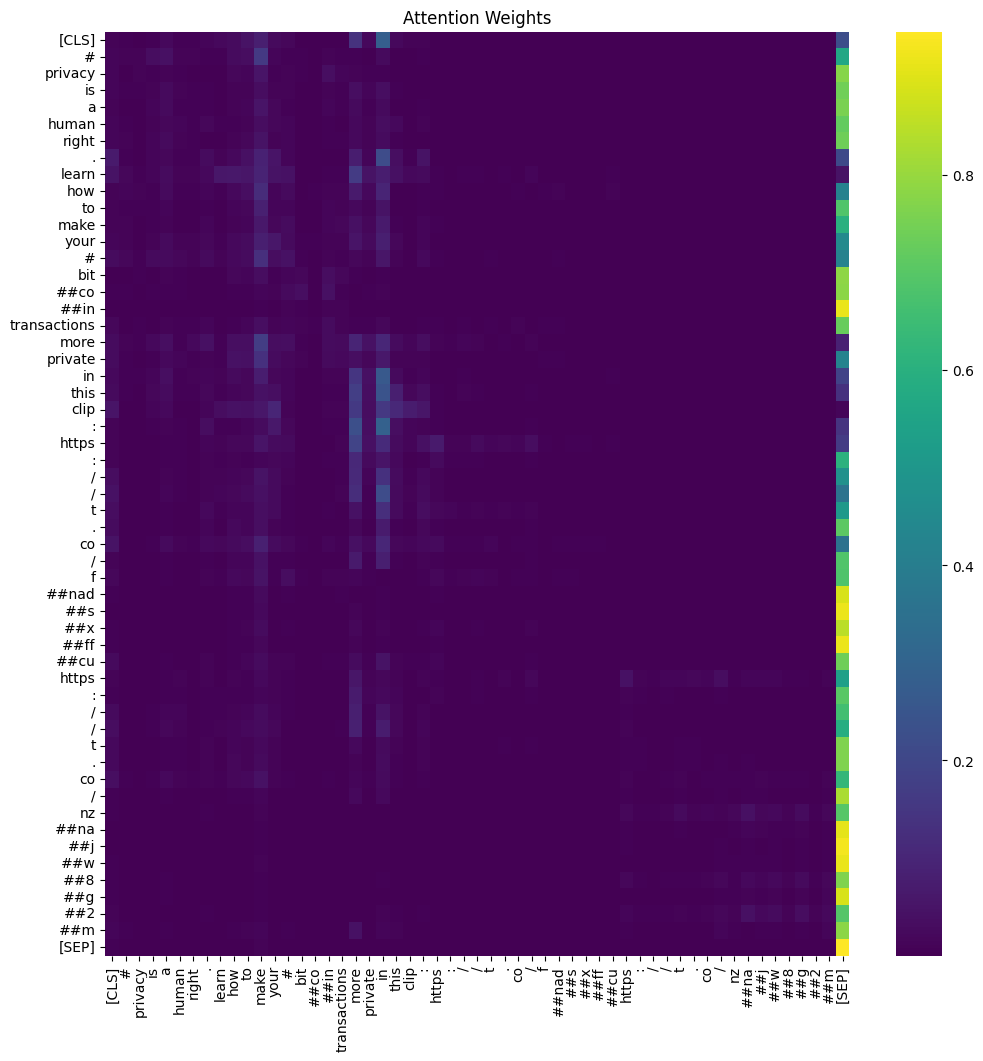

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample Text
sample_text = df['full_text'].iloc[0]
print(f"Sample Text: {sample_text}")

# Tokenize the sample text
input_id, attention_mask = encode_texts([sample_text])
input_id_tensor = tf.convert_to_tensor(input_id)
attention_mask_tensor = tf.convert_to_tensor(attention_mask)

# Extract tokens from input_id for visualization
tokens = tokenizer.convert_ids_to_tokens(input_id_tensor[0].numpy())

# Get model outputs
outputs = model(input_ids=input_id_tensor, attention_mask=attention_mask_tensor, output_attentions=True)
attentions = outputs.attentions

# Extract attention weights for one of the attention heads
# (picking the first head of the last layer for demonstration)
attention_matrix = attentions[-1][0][0].numpy()

# Visualize the attention weights
plt.figure(figsize=(12,12))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.title("Attention Weights")
plt.show()


In [ ]:
# Given the earlier tokenization and model prediction setup
input_id, attention_mask = encode_texts([sample_text])
input_id_tensor = tf.convert_to_tensor(input_id)
attention_mask_tensor = tf.convert_to_tensor(attention_mask)

logits = model({'input_ids': input_id_tensor, 'attention_mask': attention_mask_tensor}).logits
probabilities = tf.nn.softmax(logits)

positive_intensity = probabilities[0][2].numpy()  # Assuming POSITIVE is at index 2
neutral_intensity = probabilities[0][1].numpy()   # Assuming NEUTRAL is at index 1
negative_intensity = probabilities[0][0].numpy()  # Assuming NEGATIVE is at index 0

print(f"Positive Intensity: {positive_intensity:.2f}")
print(f"Neutral Intensity: {neutral_intensity:.2f}")
print(f"Negative Intensity: {negative_intensity:.2f}")


Positive Intensity: 0.00
Neutral Intensity: 1.00
Negative Intensity: 0.00


In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Analyze the sample text
sentiment = analyzer.polarity_scores(sample_text)

# Display the results
print(f"Positive Intensity: {sentiment['pos']:.2f}")
print(f"Neutral Intensity: {sentiment['neu']:.2f}")
print(f"Negative Intensity: {sentiment['neg']:.2f}")
print(f"Compound Intensity (overall): {sentiment['compound']:.2f}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00
Positive Intensity: 0.00
Neutral Intensity: 1.00
Negative Intensity: 0.00
Compound Intensity (overall): 0.00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Topic: 0 
Words: 0.091*"btc" + 0.028*"short" + 0.024*"support" + 0.023*"down" + 0.021*"still" + 0.021*"trading" + 0.020*"long" + 0.019*"would" + 0.016*"looking" + 0.015*"at"

Topic: 1 
Words: 0.104*"us" + 0.061*"think" + 0.046*"going" + 0.038*"coin" + 0.035*"people" + 0.027*"best" + 0.019*"twitter" + 0.016*"ago" + 0.015*"amazing" + 0.015*"years"

Topic: 2 
Words: 0.036*"via" + 0.034*"pay" + 0.031*"profit" + 0.024*"pepe" + 0.022*"doge" + 0.021*"vip" + 0.019*"am" + 0.017*"top" + 0.017*"target" + 0.015*"coins"

Topic: 3 
Words: 0.185*"our" + 0.035*"following" + 0.033*"hit" + 0.028*"data" + 0.024*"halving" + 0.023*"case" + 0.021*"find" + 0.017*"pm" + 0.015*"rally" + 0.015*"large"

Topic: 4 
Words: 0.089*"to" + 0.045*"and" + 0.044*"is" + 0.038*"for" + 0.032*"we" + 0.029*"this" + 0.024*"it" + 0.021*"will" + 0.020*"be" + 0.019*"that"

Topic: 5 
Words: 0.246*"no" + 0


Coherence Score:  0.4064987490354855


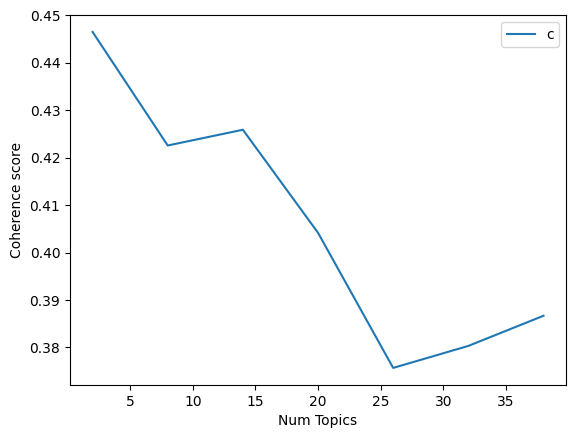

In [ ]:
import pandas as pd
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Load the dataset from Google Drive (assuming it's present in your Google Drive's root)
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/testdata.csv')

# Pre-process the data
# Convert to list
data = df.full_text.values.tolist()

# Tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))

# Create Dictionary and Corpus
id2word = Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]

# Build the LDA model
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=10,
                   random_state=100,
                   update_every=1,
                   chunksize=100,
                   passes=10,
                   alpha='auto',
                   per_word_topics=True)

# View the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

# Compute Coherence Score to validate the number of topics
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Plotting the coherence scores to determine the optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=2, limit=40, step=6)
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


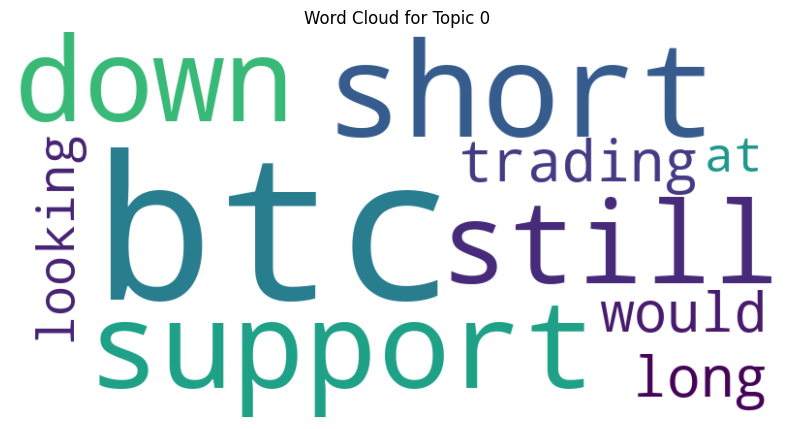

In [ ]:
from wordcloud import WordCloud

def plot_word_cloud(lda_model, topic_idx):
    terms = lda_model.show_topic(topic_idx)
    terms_dict = {term[0]: term[1] for term in terms}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(terms_dict)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Topic {topic_idx}")
    plt.axis('off')
    plt.show()

# Plotting word cloud for topic 0 as an example
plot_word_cloud(lda_model, 0)


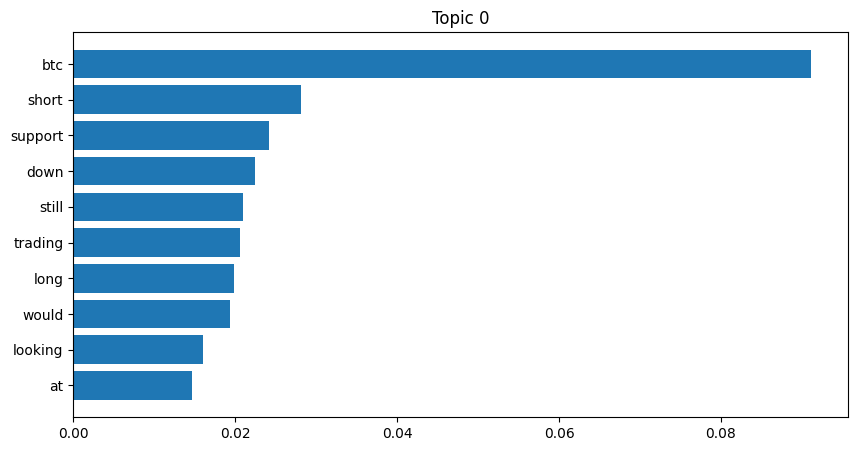

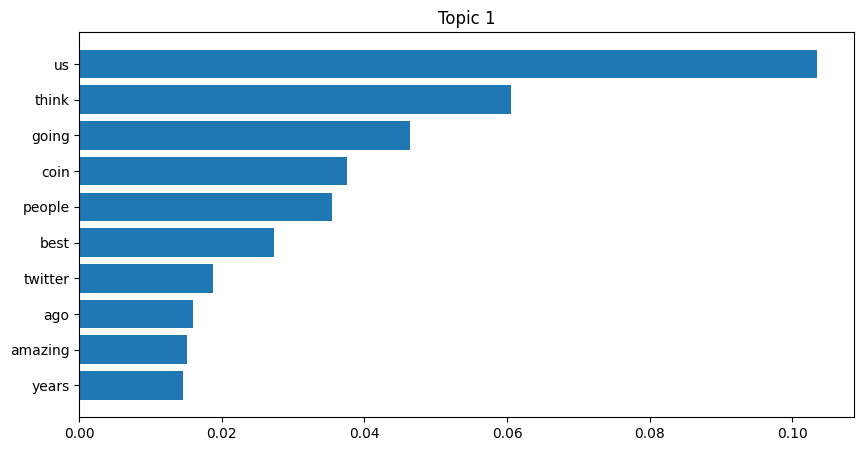

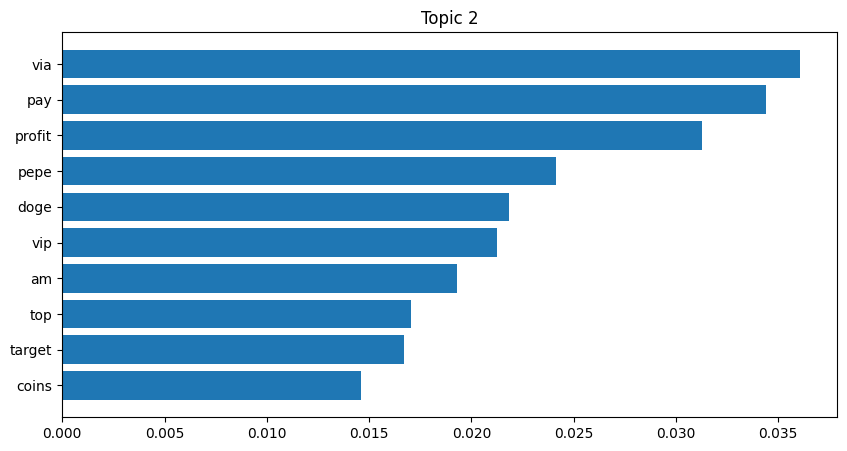

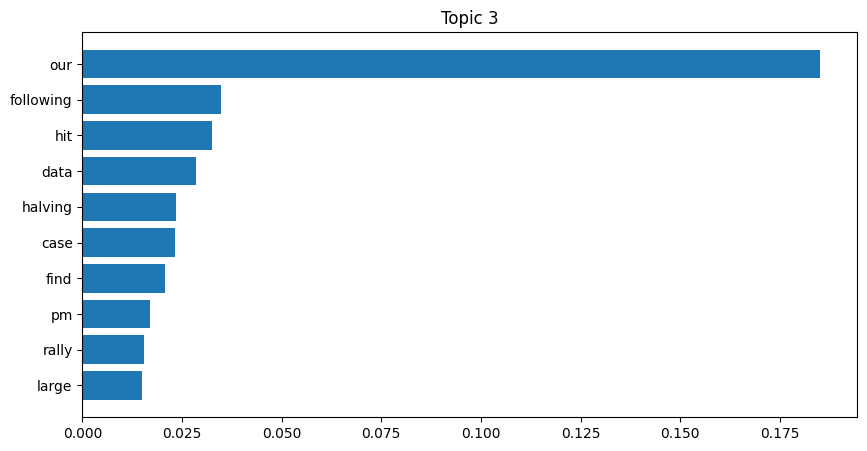

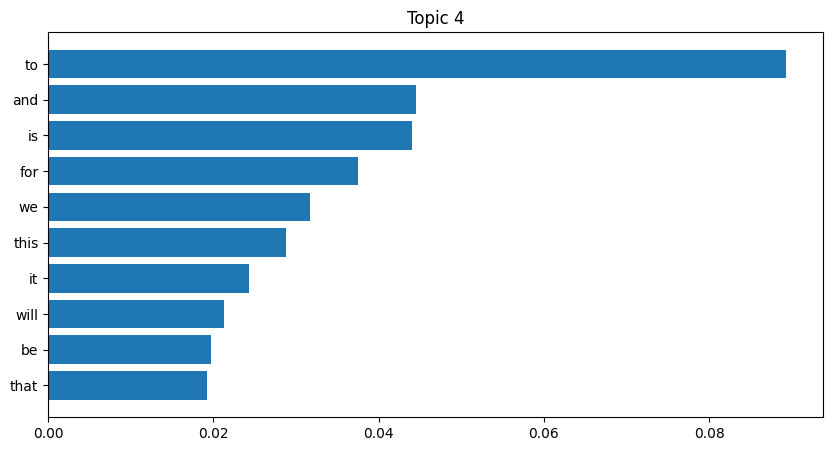

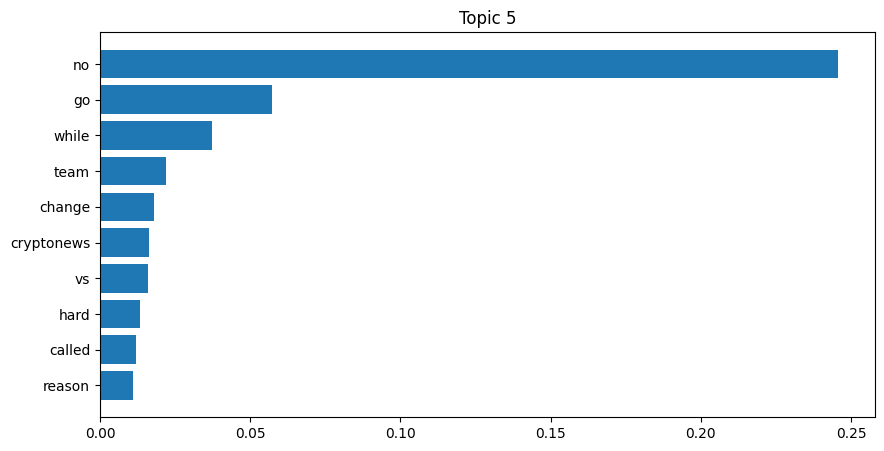

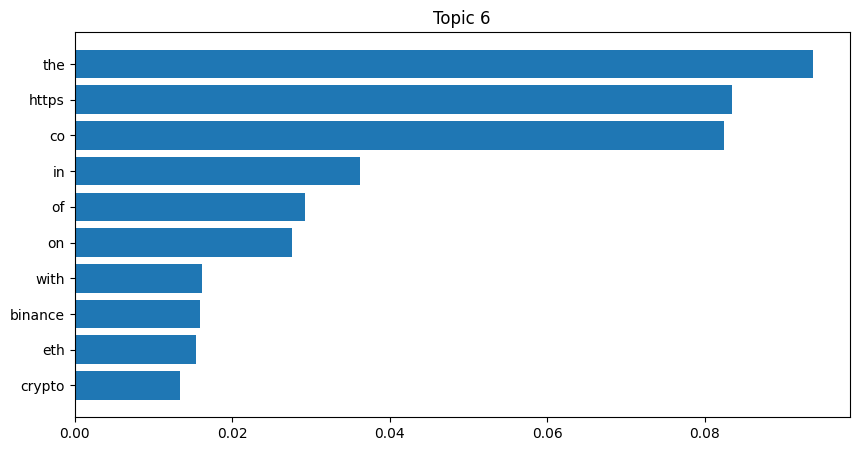

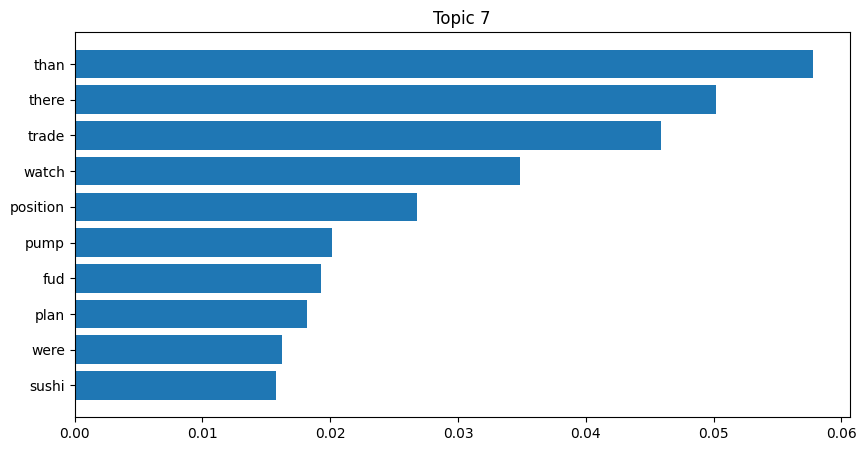

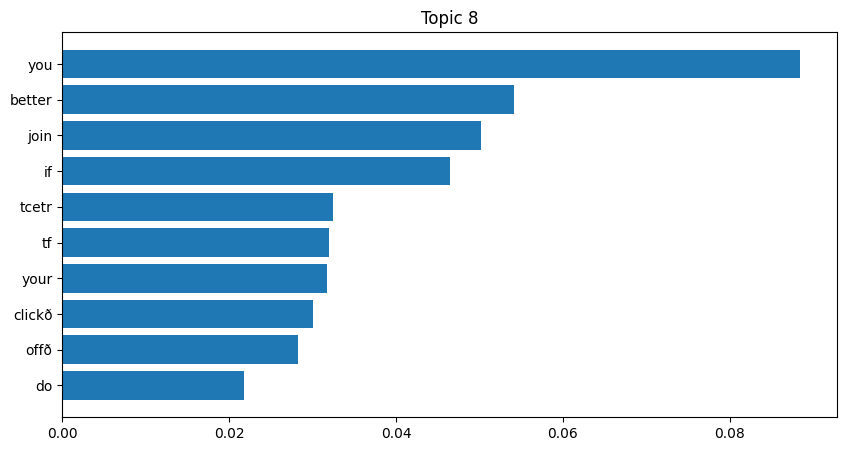

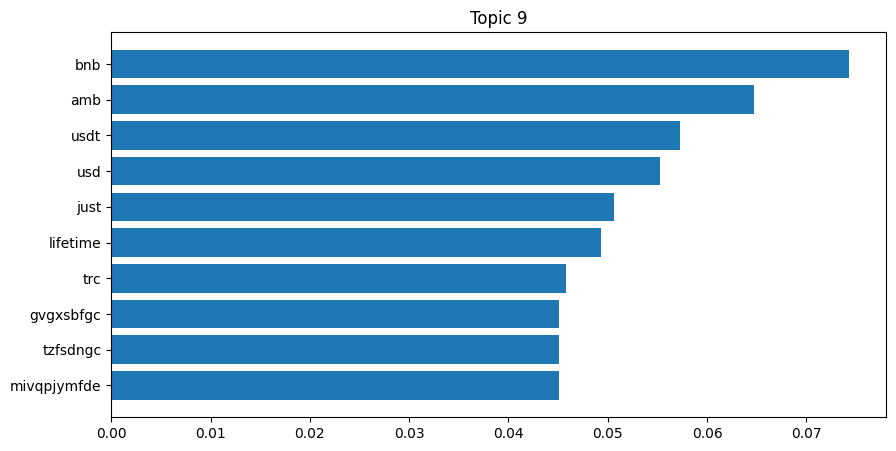

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_words(lda_model, n_words=10):
    topics = lda_model.show_topics(num_topics=-1, num_words=n_words, formatted=False)
    for idx, topic in topics:
        words = [word[0] for word in topic]
        weights = [word[1] for word in topic]

        plt.figure(figsize=(10,5))
        plt.barh(words, weights)
        plt.title(f"Topic {idx}")
        plt.gca().invert_yaxis()
        plt.show()

plot_top_words(lda_model)


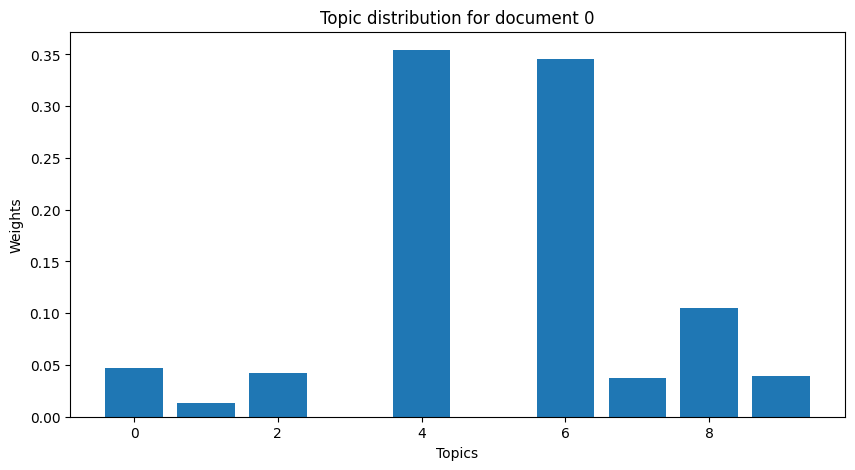

In [ ]:
def document_topic_distribution(lda_model, corpus, document_idx=0):
    topic_weights = lda_model.get_document_topics(corpus[document_idx])
    topics = [topic[0] for topic in topic_weights]
    weights = [topic[1] for topic in topic_weights]

    plt.figure(figsize=(10,5))
    plt.bar(topics, weights)
    plt.title(f"Topic distribution for document {document_idx}")
    plt.xlabel("Topics")
    plt.ylabel("Weights")
    plt.show()

document_topic_distribution(lda_model, corpus)


In [ ]:
from sklearn.model_selection import train_test_split

# Selecting relevant columns
X = df[['compound', 'importance_coefficient']]
y = df['favorite_count']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


NameError: ignored

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/testdata.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         16512 non-null  int64  
 1   created_at                         16512 non-null  object 
 2   favorite_count                     16512 non-null  int64  
 3   full_text                          16512 non-null  object 
 4   reply_count                        16512 non-null  int64  
 5   retweet_count                      16512 non-null  int64  
 6   user_id                            16512 non-null  object 
 7   clean_text                         16512 non-null  object 
 8   importance_coefficient             16512 non-null  float64
 9   importance_coefficient_normalized  16512 non-null  float64
 10  new_coins                          16512 non-null  object 
 11  scores                             16512 non-null  obj